# UE6 – Cardiovascular Disease Risk Prediction (ML Part)

This notebook implements the machine learning component for the UE6 project,
using the "Cardiovascular Diseases Risk Prediction" dataset (CVD_cleaned.csv).

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)

from xgboost import XGBClassifier

# Load dataset
data = pd.read_csv("data/CVD_cleaned.csv")
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


## Basic dataset overview

In [2]:
print("Shape (rows, columns):", data.shape)
print("\nColumn types:")
print(data.dtypes)

Shape (rows, columns): (308854, 19)

Column types:
General_Health                   object
Checkup                          object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                     float64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption             float64
Fruit_Consumption               float64
Green_Vegetables_Consumption    float64
FriedPotato_Consumption         float64
dtype: object


## Class distribution of the target variable

In [3]:
print("\nHeart_Disease value counts:")
print(data["Heart_Disease"].value_counts())
print("\nHeart_Disease (relative frequency):")
print(data["Heart_Disease"].value_counts(normalize=True))


Heart_Disease value counts:
Heart_Disease
No     283883
Yes     24971
Name: count, dtype: int64

Heart_Disease (relative frequency):
Heart_Disease
No     0.91915
Yes    0.08085
Name: proportion, dtype: float64


## Missing values check

In [4]:
missing_counts = data.isnull().sum()
print(missing_counts)
print("\nTotal missing values:", missing_counts.sum())

General_Health                  0
Checkup                         0
Exercise                        0
Heart_Disease                   0
Skin_Cancer                     0
Other_Cancer                    0
Depression                      0
Diabetes                        0
Arthritis                       0
Sex                             0
Age_Category                    0
Height_(cm)                     0
Weight_(kg)                     0
BMI                             0
Smoking_History                 0
Alcohol_Consumption             0
Fruit_Consumption               0
Green_Vegetables_Consumption    0
FriedPotato_Consumption         0
dtype: int64

Total missing values: 0


## Outliers: boxplots for numerical columns

Numeric columns: ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']


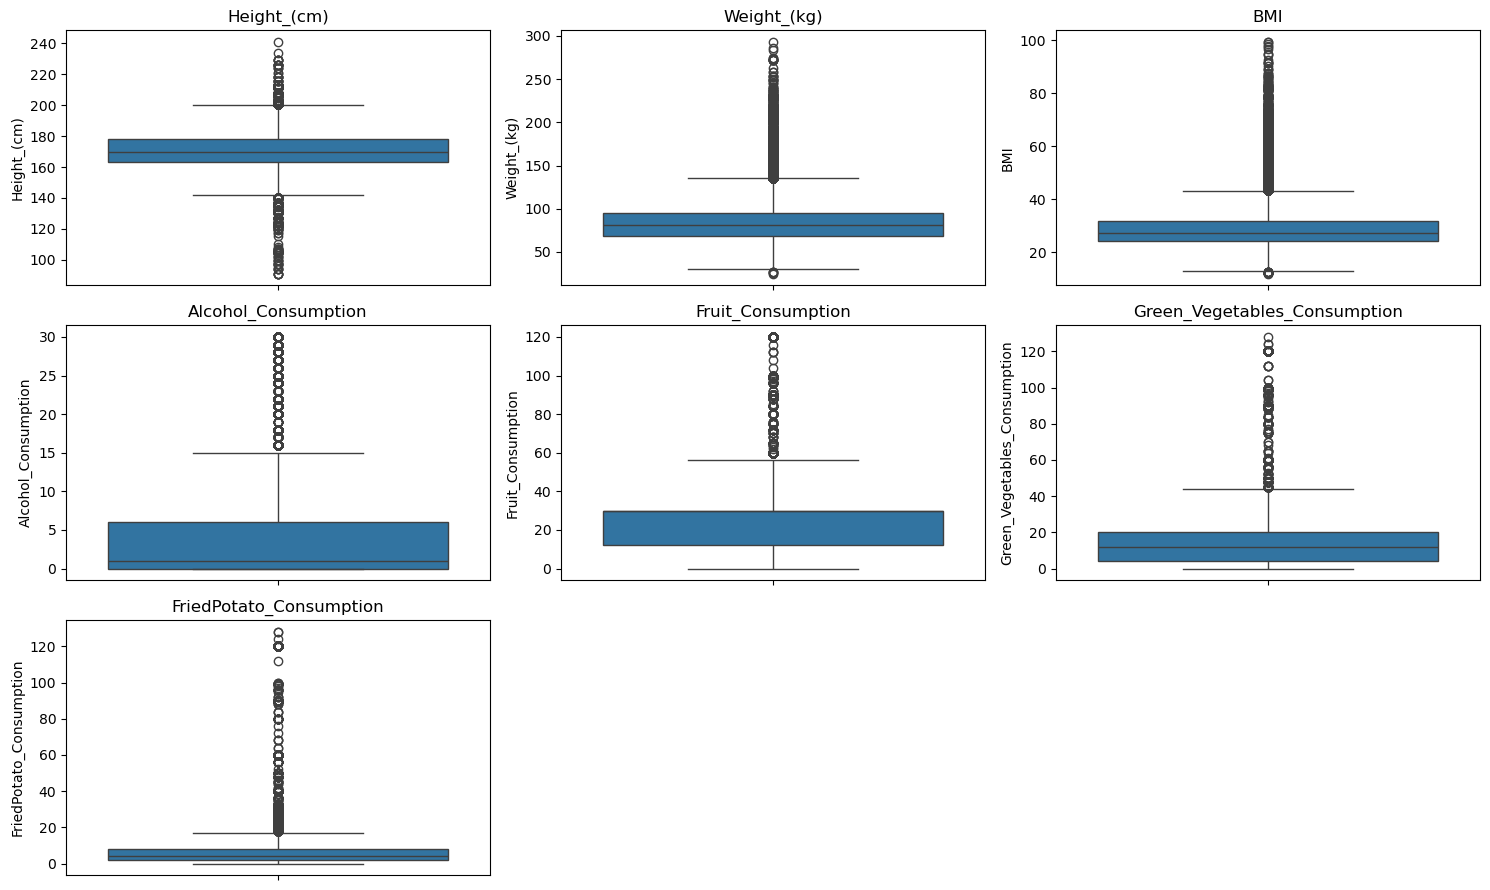

In [5]:
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Numeric columns:", numeric_cols)

n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(5 * n_cols, 3 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=data[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [6]:
stats = data[numeric_cols].describe()
stats

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


## Check and remove duplicate rows

In [7]:
duplicate_count = data.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

data = data.drop_duplicates()
print("Shape after removing duplicates:", data.shape)

Number of duplicate rows: 80
Shape after removing duplicates: (308774, 19)


## Target variable

In [8]:
# Heart_Disease: Yes -> 1, No -> 0
data["Heart_Disease"] = (data["Heart_Disease"] == "Yes").astype(int)
y = data["Heart_Disease"]

# Features
feature_cols = [
    "General_Health",
    "Checkup",
    "Exercise",
    "Smoking_History",
    "Alcohol_Consumption",
    "Fruit_Consumption",
    "Green_Vegetables_Consumption",
    "FriedPotato_Consumption",
    "Sex",
    "Age_Category",
    "BMI",
    "Diabetes",
    "Depression",
    "Arthritis"
]

X = data[feature_cols]

# Categorical and numerical predictors
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical features:", cat_cols)
print("Numerical features:", num_cols)

Categorical features: ['General_Health', 'Checkup', 'Exercise', 'Smoking_History', 'Sex', 'Age_Category', 'Diabetes', 'Depression', 'Arthritis']
Numerical features: ['Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'BMI']


## Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (247019, 14)  Test size: (61755, 14)


## Preprocessing: scale numeric, one-hot encode categorical

In [10]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

## Logistic Regression model

In [11]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # handle class imbalance
)

logreg_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", log_reg)
    ]
)

logreg_clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

## Random Forest model

In [12]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", rf)
    ]
)

rf_clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

## XGBoost model

In [13]:
xgb = XGBClassifier(
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),
    eval_metric="logloss",
)

xgb_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", xgb)
    ]
)

xgb_clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

In [14]:
def evaluate_model(name, model, X_test, y_test, threshold=0.5):
    """
    Prints classification metrics, plots ROC curve
    and confusion matrices (counts + normalised) 
    for a given decision threshold.
    """
    y_prob = model.predict_proba(X_test)[:, 1]

    y_pred = (y_prob >= threshold).astype(int)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    print(f"=== {name} (threshold = {threshold:.2f}) ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC AUC  : {auc:.3f}\n")

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix (counts):")
    print(cm)

    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve - {name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Confusion matrix heatmaps - counts
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix - {name} (counts)")
    plt.tight_layout()
    plt.show()

    # Confusion matrix heatmaps - Normalised by true class
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix - {name} (normalized)")
    plt.tight_layout()
    plt.show()

## Logistic Regression model Evaluation

=== Logistic Regression (threshold = 0.50) ===
Accuracy : 0.737
Precision: 0.208
Recall   : 0.801
F1-score : 0.330
ROC AUC  : 0.838

Confusion matrix (counts):
[[41531 15230]
 [  992  4002]]


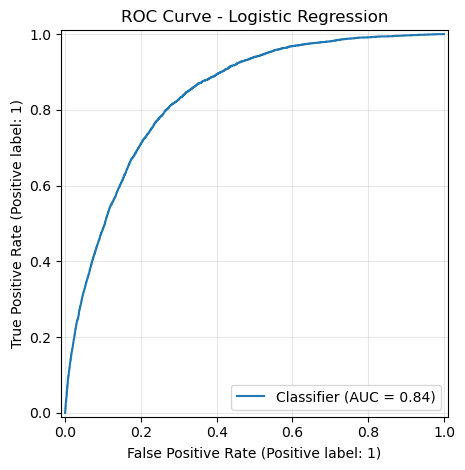

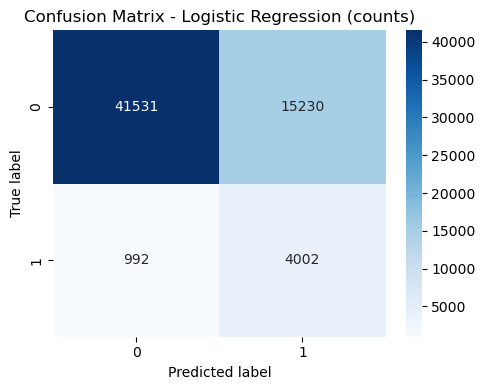

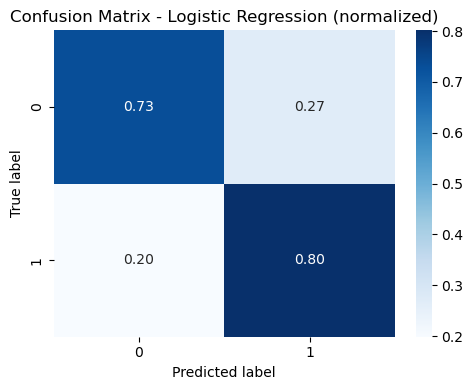

In [15]:
evaluate_model("Logistic Regression", logreg_clf, X_test, y_test)

## Feature importance: Logistic Regression coefficients

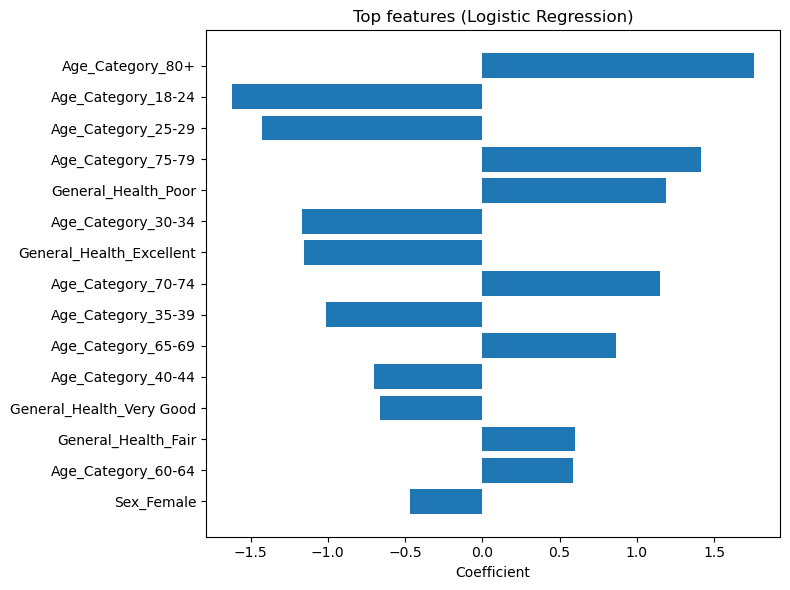

In [16]:
ohe = logreg_clf.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_feature_names])

coef = logreg_clf.named_steps["clf"].coef_[0]

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coef,
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(coef_df["feature"].head(top_n)[::-1],
         coef_df["coef"].head(top_n)[::-1])
plt.xlabel("Coefficient")
plt.title("Top features (Logistic Regression)")
plt.tight_layout()
plt.show()

## Random Forest model evaluation

=== Random Forest (threshold = 0.20) ===
Accuracy : 0.858
Precision: 0.264
Recall   : 0.422
F1-score : 0.324
ROC AUC  : 0.801

Confusion matrix (counts):
[[50884  5877]
 [ 2889  2105]]


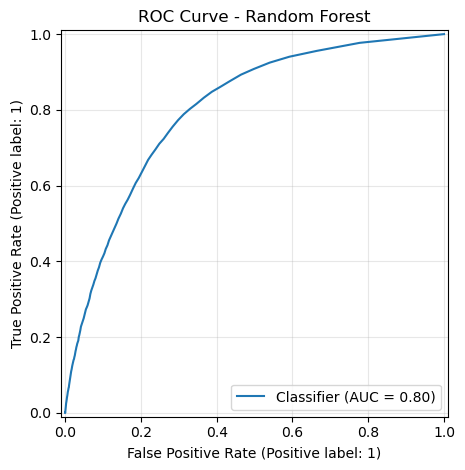

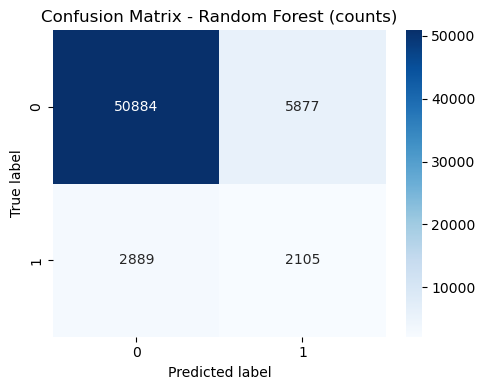

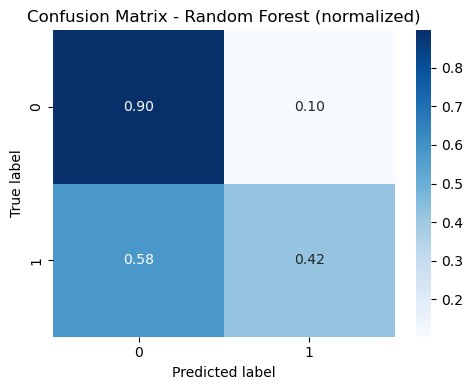

In [17]:
# evaluate_model("Random Forest", rf_clf, X_test, y_test)
evaluate_model("Random Forest", rf_clf, X_test, y_test, threshold=0.2)

## Feature importance: Random Forest

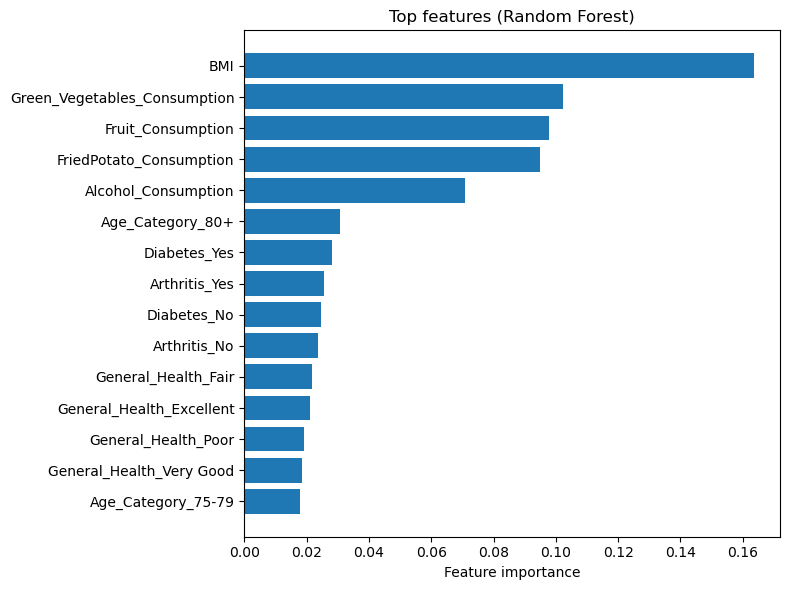

In [18]:
rf_model = rf_clf.named_steps["clf"]
rf_importances = rf_model.feature_importances_

rf_imp_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(rf_imp_df["feature"].head(top_n)[::-1],
         rf_imp_df["importance"].head(top_n)[::-1])
plt.xlabel("Feature importance")
plt.title("Top features (Random Forest)")
plt.tight_layout()
plt.show()

## XGBoost model evaluation

=== XGBoost (threshold = 0.50) ===
Accuracy : 0.741
Precision: 0.208
Recall   : 0.780
F1-score : 0.328
ROC AUC  : 0.832

Confusion matrix (counts):
[[41879 14882]
 [ 1097  3897]]


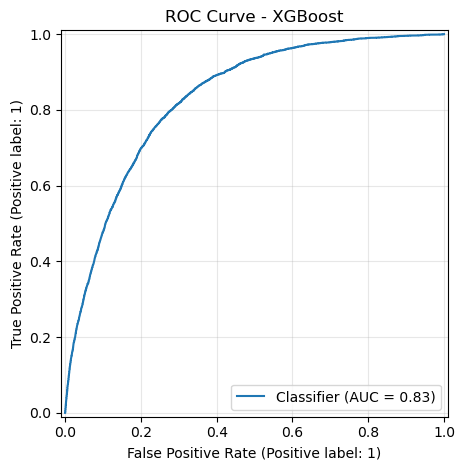

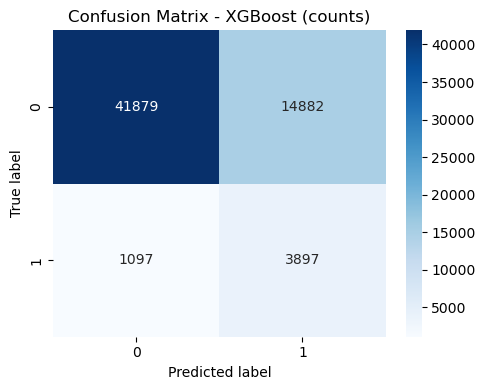

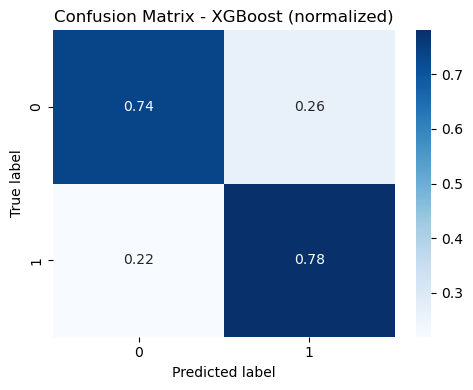

In [19]:
# evaluate_model("XGBoost", xgb_clf, X_test, y_test)
evaluate_model("XGBoost", xgb_clf, X_test, y_test, threshold=0.5)

## Feature importance: XGBoost

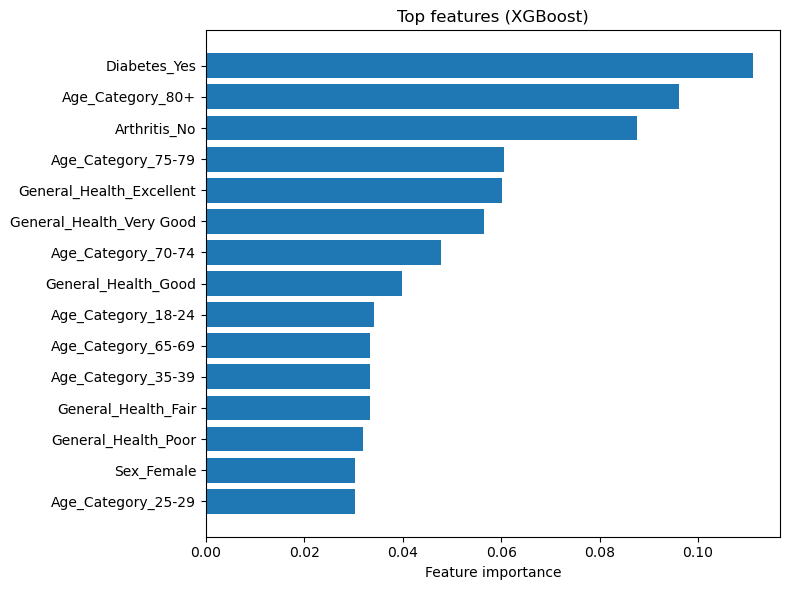

In [20]:
xgb_model = xgb_clf.named_steps["clf"]
xgb_importances = xgb_model.feature_importances_

xgb_imp_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": xgb_importances
}).sort_values("importance", ascending=False)

top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(xgb_imp_df["feature"].head(top_n)[::-1],
         xgb_imp_df["importance"].head(top_n)[::-1])
plt.xlabel("Feature importance")
plt.title("Top features (XGBoost)")
plt.tight_layout()
plt.show()

In [ ]:
# Persist trained models and metrics
from pathlib import Path
import joblib, json

# Ensure models directory exists
Path("models").mkdir(exist_ok=True)

# Save pipelines
joblib.dump(logreg_clf, "models/logreg.pkl")
joblib.dump(rf_clf, "models/rf.pkl")
joblib.dump(xgb_clf, "models/xgb.pkl")

def compute_metrics(model, X_test, y_test, threshold=0.5):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred)),
        "recall": float(recall_score(y_test, y_pred)),
        "f1": float(f1_score(y_test, y_pred)),
        "roc_auc": float(roc_auc_score(y_test, y_prob)),
        "threshold": float(threshold)
    }

# Use thresholds consistent with earlier evaluation
metrics = {
    "logreg": compute_metrics(logreg_clf, X_test, y_test, threshold=0.5),
    "rf":     compute_metrics(rf_clf,     X_test, y_test, threshold=0.2),
    "xgb":    compute_metrics(xgb_clf,    X_test, y_test, threshold=0.5),
}

with open("models/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)
print("Saved models to models/*.pkl and metrics to models/metrics.json")